# Predict Remaining Useful Life

In this example, we will generate labels using Compose on data provided by NASA simulating turbofan engine degradation. The labels can be used to train a machine learning model to predict the Remaining Useful Life (RUL) of an engine.

In [1]:
import composeml as cp
import data

## Load Data
In this dataset, we have 249 engines (`engine_no`) which are monitored over time (`time_in_cycles`). Each engine had `operational_settings` and `sensor_measurements` recorded for each cycle. The **Remaining Useful Life** (RUL) is the amount of cycles an engine has left before it needs maintenance. What makes this dataset special is that the engines run all the way until failure, giving us precise RUL information for every engine at every point in time.

You can download the data directly from NASA [here](https://ti.arc.nasa.gov/c/13/). After downloading the data, you can set `file` as an absolute path to the file `train_FD004.txt`. With the file in place, we preview the data to get an idea on how to observations look.

In [2]:
df = data.load('data/train_FD004.txt')

df[df.columns[:7]].head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2
0,1,1,42.0049,0.8400,100.0,445.00,549.68
1,1,2,20.0020,0.7002,100.0,491.19,606.07
2,1,3,42.0038,0.8409,100.0,445.00,548.95
3,1,4,42.0000,0.8400,100.0,445.00,548.70
4,1,5,25.0063,0.6207,60.0,462.54,536.10


## Generate Labels
Now with the observations loaded, we are ready to generate labels for our prediction problem.


### Define Labeling Function
To get started, we define the labeling function that will return the RUL given the remaining observations of an engine at a point in time.

In [3]:
def remaining_useful_life(df):
    return len(df) - 1

### Create Label Maker
With the labeling function, we create the label maker for our prediction problem. To process RUL for each engine, we set the `target_entity` to the engine number. Additionally, to get the remaining observations of an engine, we leave `window_size` as `None`. This will set the window size to the total number of observations.

In [4]:
lm = cp.LabelMaker(
    target_entity='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

### Search Labels
Let's imagine we want to make predictions on turbines that are up and running. Turbines in general don't fail before 120 cycles, so we will only make labels for engines that reach at least 100 cycles. To do this, the `minimum_data` parameter is set to 100. Using Compose, we can easily tweak this parameter as the requirements of our model changes. Additionally, we set `gap` as one to create labels on every cycle and limit the number of examples to 10 for each engine.

In [5]:
lt = lm.search(
    df.sort_values('time'),
    num_examples_per_instance=10,
    minimum_data=100,
    gap=1,
    verbose=True,
)

lt.head()

Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████| engine_no: 2490/2490 


,engine_no,cutoff_time,remaining_useful_life
id,,,
0,1,2000-01-01 16:40:00,220
1,1,2000-01-01 16:50:00,219
2,1,2000-01-01 17:00:00,218
3,1,2000-01-01 17:10:00,217
4,1,2000-01-01 17:20:00,216


### Describe Labels

With the generate label times, we can use `LabelTimes.describe` to print out the settings and transforms that were used to make these labels. This is useful as a reference for understanding how the labels were generated from raw data.

In [6]:
lt.describe()

Settings
--------
num_examples_per_instance       10
minimum_data                   100
window_size                  61249
gap                              1


Transforms
----------
No transforms applied



### Plot Labels

Additionally, there are plots available for insight to the labels.


#### Distribution

This plot shows the label distribution.

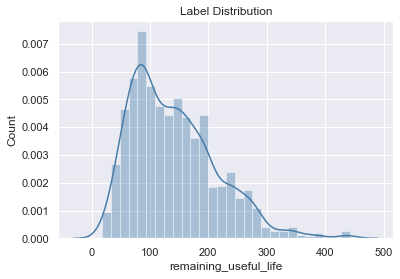

In [7]:
lt.plot.distribution();

#### Count by Time

This plot shows the label count accumulated across cutoff times.

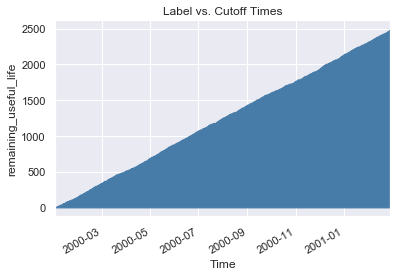

In [8]:
lt.plot.count_by_time();